## Import packages

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pyepo
from pyepo.model.grb import optGrbModel
import torch
from torch import nn
from torch.utils.data import DataLoader
from gurobipy import Model, GRB, quicksum
from sklearn.preprocessing import StandardScaler
import pandas as pd
import wandb 
wandb.login()
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm
from pyepo.metric.regretParams import regretParams
# train model

#from sklearn_extra.cluster import KMedoids
import copy

Auto-Sklearn cannot be imported.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederikskoufertin (Pyepo_special). Use `wandb login --relogin` to force relogin


# Load data

In [2]:
# load data
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
# green = (0.31, 1, 0.34) # (79, 255, 87)
green = (0.122, 00.816, 0.51) # (31, 208, 130)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 53.32 # 90% quantile



def import_data(negative_prices=False):
    # import data and set constants
    all_data = pd.read_csv("2020_data.csv")
    prices_UP = np.maximum(all_data["UP"].to_numpy(),0)
    prices_DW = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    nominal_wind = 10
    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    price_H = 35.2
    penalty = np.quantile(prices_UP, 0.95) # 95% quantile of deficit_settle price over all 2 years
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_UP,
        prices_DW,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        penalty
    )

In [3]:
#Import data
(prices_UP,prices_DW,prices_F,prices_forecast,features,features_red,realized,price_H,penalty) = import_data()

# Change forward prices to forecast prices in features
features["forward"] = prices_forecast

periods = list(range(0, len(prices_F) )) # Total time considered 2020-2021
n_periods = 24 # Number of periods in a day
n_days = 365 # Number of days in training set and test set
n_hours = n_days * n_periods
# 4 without extra hydrogen, 5 with extra hydrogen
num_cost = 5 # number of cost parameters
num_feat = n_periods*6 # size of feature
num_feat_rf = 2 # size of feature
num_item = num_cost*n_periods # number of predictions (Forward bid and Hydrogen)
#n_val_days = 10 # number of validation days 
#n_hours_val = n_periods*n_val_days
lambda_H_list = [price_H for i in range(n_periods)]
penalty_list = [-penalty for i in range(n_periods)]

def flatten_extend(matrix):
     flat_list = []
     for row in matrix:
         flat_list.extend(row)
     return flat_list

# Define optimization model and prediction model

## Optimization model

In [4]:
from pyepo.model.grb import optGrbModel
num_item = 4*n_periods # number of predictions (Forward bid and Hydrogen)

# optimization model
class hydrogenPlanning(optGrbModel):
    def __init__(self, realized, *args, **kwargs):        
        #Fixed parameters
        self.max_elec = 10
        self.max_wind = 10
        self.nominal_wind = 10
        self.min_production = 50
        self.periods = np.arange(len(realized))
        self.E_real = realized
        super().__init__()

    def _getModel(self):

        self.initial_plan = Model("Gurobi.Optimizer")

        # Definition of variables
        self.var = self.initial_plan.addVars((4*len(self.periods)), name="x")
        # 1-24: Hydrogen plan, 25-48: Forward bids, 49-72: Up regulation, 73-96: Down regulation
        # Objective: Maximize profit
        self.initial_plan.modelSense = GRB.MAXIMIZE

        # Constraints
        # Max capacity
        
        self.initial_plan.addConstr(self.min_production <= gp.quicksum(self.var[t] for t in self.periods), name="min_hydrogen_production")
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"elec_capacity_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_elec, name=f"elec_capacity_ub_{t}")
        for t in np.arange(len(self.periods),2*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= -self.max_elec, name=f"wind_capacity_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_wind, name=f"wind_capacity_ub_{t}")
        for t in np.arange(2*len(self.periods),3*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"up_regulation_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= 10*self.max_wind, name=f"up_regulation_ub_{t}")
        for t in np.arange(3*len(self.periods),4*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"dw_regulation_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= 10*self.max_wind, name=f"dw_regulation_ub_{t}")
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.E_real[t] - self.var[t] - self.var[t+24] == -self.var[t+48] + self.var[t+72], name=f"balancing_{t}")
            #initial_plan.addConstr(-x[0,t] + self.min_production/len(self.periods) - x[4,t] <= 0, name=f"slack_{t}")
        self.initial_plan.addConstr(gp.quicksum(self.var[t] for t in np.arange(0,len(self.periods))) == self.min_production, name="min_hydrogen_production")
        
        return self.initial_plan, self.var
    
    def setObjective(self, c):
        # Objective: Maximize profit
        self.initial_plan.setObjective(gp.quicksum(self.var[t]*c[t] for t in np.arange(0,4*len(self.periods))), GRB.MAXIMIZE)

    def get_plan(self):
        self.initial_plan.optimize()
        self.initial_plan.update()
        x_values = []
        for var in self.initial_plan.getVars():
            x_values.append(var.x)
        hydrogen = x_values[0:len(self.periods)]
        forward_bids = x_values[len(self.periods):2*len(self.periods)]
        return forward_bids, hydrogen


## Prepare data as tensors

#### All data is split into training and test data, 2019 is training data and 2020 is test data.

In [5]:
### Get wind data for training and test ###
nominal_wind = 10
forecast_wind = features['production_FC'].to_numpy()*nominal_wind
wind_train = np.asarray([flatten_extend([realized[d:d+n_periods]]) for d in range(int(n_hours/n_periods))])
wind_test = np.asarray([flatten_extend([forecast_wind[d:d+n_periods]]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])

### Get feature data for training and test ###
x_train_df = features.iloc[:n_hours]
x_test_df = features.iloc[n_hours:(n_hours+n_hours)]

# Create a StandardScaler object (fitted on train data)
scaler = StandardScaler()
scaler.fit(x_train_df)

# Standardize train and test dataframes separately
x_train_df = pd.DataFrame(scaler.transform(x_train_df), columns=x_train_df.columns)
x_test_df = pd.DataFrame(scaler.transform(x_test_df), columns=x_test_df.columns)

x_train = []
x_test = []
for i in range(0, len(x_train_df), 24):
    x_train.append((x_train_df.iloc[i:i+24]).values.T.flatten())  # Extract 24 rows for each day and flatten to 1D array
for i in range(0, len(x_test_df), 24):
    x_test.append((x_test_df.iloc[i:i+24]).values.T.flatten()) # Extract 24 rows for each day and flatten to 1D array

### Get cost data for training and test ###
c_train = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods]]) for d in range(int(n_hours/n_periods))])
c_test = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods]]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])


In [6]:
from pyepo.data.datasetParams import optDatasetParams
dataset_train = optDatasetParams(hydrogenPlanning, x_train, c_train, wind_train)
#dataset_val = optDatasetParams(hydrogenPlanning, x_val, c_val, wind_val)
dataset_test = optDatasetParams(hydrogenPlanning, x_test, c_test, wind_test)

batch_size = 1
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
#loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


  0%|          | 0/365 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-10


100%|██████████| 365/365 [00:03<00:00, 119.98it/s]


Optimizing for optDataset...


100%|██████████| 365/365 [00:03<00:00, 121.01it/s]


## Construct Neural Network Class

In [25]:
# prediction model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size,neurons,dropout):
        super(LinearRegression, self).__init__()
        #self.linear = nn.Linear(num_feat, num_item)
        self.linear = nn.Sequential( 
            nn.Linear(input_size, neurons),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(neurons, neurons),
            nn.ReLU(),
            nn.Linear(neurons, output_size)
        )

    def forward(self, x):
        out = self.linear(x)
        return out


# SLO NN model training

Optimize for regret, which will have to be done on validation set 

In [58]:
def trainModel(config=None):#, num_epochs=20, lr=1e-2):
    
    with wandb.init(config=config):
        start_time = time.time()
        config = wandb.config
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        #pprint(config)
        reg = LinearRegression(num_feat, config.num_item, config.neurons, config.dropout)
        # cuda
        if torch.cuda.is_available():
            reg = reg.cuda()
        # set adam optimizer
        optimizer = torch.optim.Adam(reg.parameters(), lr=config.lr)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = config.gamma)
        criterion = torch.nn.MSELoss()
        # train mode
        reg.train()
        # init log
        loss_log = []
        # using validation regret instead of test regret
        for data in loader_test:
            print(data)
            break
        loss_log_regret = [regretParams(reg, config.optmodel, loader_test, wind_test)]
        
        wandb.watch(reg, log_freq=100)
        for epoch in range(config.num_epochs):
            # start timing
            # load data
            l = []
            for i, data in enumerate(tqdm(config.train_data)):
                x, c, w, z = data
                # cuda
                if torch.cuda.is_available():
                    x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
                # forward pass
                cp = reg(x)
                
                loss = criterion(cp, c)
                
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # log
                l.append(np.sqrt(loss.item()))
            loss_log.append(np.mean(l))
            epoch_loss = loss
            wandb.log({"Linear loss (training)": epoch_loss})
            if config.val == True:
                # Compute validation loss and log
                l = []
                for i, data in enumerate(loader_test):
                    x, c, w, z = data
                    # cuda
                    if torch.cuda.is_available():
                        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
                    # forward pass
                    cp = reg(x)
                    loss = criterion(cp, c)
                    # log
                    l.append(np.sqrt(loss.item()))
                wandb.log({"Linear loss (validation)": np.mean(l)})

                lr_scheduler.step() # Decay learning rate
                
                # Compute validation regret and log
                regret = regretParams(reg, config.optmodel, config.test_data, wind_test)
                loss_log_regret.append(regret)
                wandb.log({"Regret (validation)": regret})
            print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
        
        # end timing and print total training runtime
        elapsed = time.time() - start_time
        print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
        
        return reg, loss_log, loss_log_regret

In [31]:
# Hyper parameters

import pprint
sweep_config = {
    'method': 'random', # grid, random
    'name' : 'SLO wo. algo 13 sweep',
    'metric': {
      'name': 'Linear loss (validation)',
      'goal': 'minimize'   
    },
}

parameters_dict =  {
        'lr': {
            'values': [1e-2, 1e-3, 1e-4]
        },
        'gamma': {
            'values': [0.9, 0.95, 0.99]
        },
        'num_epochs': {
            'values': [10, 20, 30]
        },
        'neurons': {
            'values': [32, 64, 128]
            },
        'dropout': {
            'values': [0.5, 0.7, 0.9]
        },
        "method_name": {"value":"spo+"},
        "val": {"value":True},
        "optmodel" : {"value":hydrogenPlanning},
        "num_item" : num_item,
    }
sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, entity="Pyepo_special",project="Sweep Pyepo")

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'Linear loss (validation)'},
 'name': 'SLO wo. algo 13 sweep',
 'parameters': {'dropout': {'values': [0.5, 0.7, 0.9]},
                'gamma': {'values': [0.9, 0.95, 0.99]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'method_name': {'value': 'spo+'},
                'neurons': {'values': [32, 64, 128]},
                'num_epochs': {'values': [10, 20, 30]},
                'val': {'value': True}}}
Create sweep with ID: ud75rkz4
Sweep URL: https://wandb.ai/Pyepo_special/Sweep%20Pyepo/sweeps/ud75rkz4


In [32]:
wandb.agent(sweep_id, function=trainModel, count=30)

wandb: Agent Starting Run: jh8ejrhp with config:
wandb: 	dropout: 0.7
wandb: 	gamma: 0.99
wandb: 	lr: 0.0001
wandb: 	method_name: spo+
wandb: 	neurons: 128
wandb: 	num_epochs: 20
wandb: 	val: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 365/365 [00:03<00:00, 99.46it/s] 


Epoch  1,  Loss: 5360.0288,  Regret: 350.6738%


100%|██████████| 365/365 [00:04<00:00, 79.21it/s]


Epoch  2,  Loss: 4165.7222,  Regret: 215.0695%


100%|██████████| 365/365 [00:04<00:00, 89.14it/s] 


Epoch  3,  Loss: 3804.7673,  Regret: 15.6047%


100%|██████████| 365/365 [00:03<00:00, 99.11it/s] 


Epoch  4,  Loss: 4331.4399,  Regret: 13.6270%


100%|██████████| 365/365 [00:05<00:00, 72.70it/s]


Epoch  5,  Loss: 3007.3994,  Regret: 13.3801%


100%|██████████| 365/365 [00:05<00:00, 64.83it/s]


Epoch  6,  Loss: 3156.9050,  Regret: 13.3350%


100%|██████████| 365/365 [00:05<00:00, 61.90it/s]


Epoch  7,  Loss: 2686.4290,  Regret: 13.3007%


100%|██████████| 365/365 [00:05<00:00, 68.53it/s]


Epoch  8,  Loss: 2612.1899,  Regret: 13.2315%


100%|██████████| 365/365 [00:04<00:00, 83.07it/s] 


Epoch  9,  Loss: 2860.6038,  Regret: 13.2291%


100%|██████████| 365/365 [00:05<00:00, 63.29it/s]


Epoch 10,  Loss: 1823.2189,  Regret: 13.4771%


100%|██████████| 365/365 [00:05<00:00, 71.48it/s]


Epoch 11,  Loss: 2587.3093,  Regret: 13.4601%


100%|██████████| 365/365 [00:04<00:00, 83.35it/s] 


Epoch 12,  Loss: 2177.0664,  Regret: 13.3936%


100%|██████████| 365/365 [00:05<00:00, 67.16it/s]


Epoch 13,  Loss: 2249.2717,  Regret: 13.4958%


100%|██████████| 365/365 [00:04<00:00, 73.72it/s]


Epoch 14,  Loss: 2147.2625,  Regret: 13.7557%


100%|██████████| 365/365 [00:04<00:00, 79.49it/s]


Epoch 15,  Loss: 2046.5294,  Regret: 13.4942%


100%|██████████| 365/365 [00:04<00:00, 74.06it/s]


Epoch 16,  Loss: 1816.0873,  Regret: 13.5808%


100%|██████████| 365/365 [00:04<00:00, 81.79it/s]


Epoch 17,  Loss: 1921.1920,  Regret: 13.5792%


100%|██████████| 365/365 [00:03<00:00, 95.98it/s] 


Epoch 18,  Loss: 2376.6023,  Regret: 13.6931%


100%|██████████| 365/365 [00:05<00:00, 61.62it/s]


Epoch 19,  Loss: 1863.7163,  Regret: 13.5780%


100%|██████████| 365/365 [00:05<00:00, 65.90it/s]


Epoch 20,  Loss: 1794.0824,  Regret: 13.5770%
Total Elapsed Time: 134.72 Sec.


Linear loss (training),█▅▂▃▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁
Linear loss (validation),█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Regret (validation),█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Linear loss (training),88.73575
Linear loss (validation),23.91419
Regret (validation),0.13577


wandb: Ctrl + C detected. Stopping sweep.


## Train the tuned neural network

In [20]:
# Redo training with best hyperparameters
best_config={
        'lr': 1e-2,
        'gamma': 0.99,
        'num_epochs': 30,
        'neurons': 64,
        'dropout': 0.7,
        "method_name": "spo+",
        "val" : False,
        "optmodel" : hydrogenPlanning,
        "num_item" : num_item,
    }

reg, loss_log, loss_log_regret = trainModel(best_config)

100%|██████████| 365/365 [00:02<00:00, 126.23it/s]


Epoch  1,  Loss: 5641.0552,  Regret: 324.4115%


100%|██████████| 365/365 [00:02<00:00, 124.48it/s]


Epoch  2,  Loss: 5655.7720,  Regret: 343.9469%


100%|██████████| 365/365 [00:03<00:00, 106.92it/s]


Epoch  3,  Loss: 5297.1465,  Regret: 347.2936%


100%|██████████| 365/365 [00:03<00:00, 117.21it/s]


Epoch  4,  Loss: 5446.7534,  Regret: 345.4325%


100%|██████████| 365/365 [00:02<00:00, 125.96it/s]


Epoch  5,  Loss: 4821.5576,  Regret: 348.5887%


100%|██████████| 365/365 [00:02<00:00, 125.25it/s]


Epoch  6,  Loss: 4702.3647,  Regret: 347.8511%


100%|██████████| 365/365 [00:02<00:00, 129.37it/s]


Epoch  7,  Loss: 3842.2910,  Regret: 341.3375%


100%|██████████| 365/365 [00:03<00:00, 121.33it/s]


Epoch  8,  Loss: 4453.5200,  Regret: 329.8095%


100%|██████████| 365/365 [00:03<00:00, 113.57it/s]


Epoch  9,  Loss: 4966.8179,  Regret: 317.3114%


100%|██████████| 365/365 [00:02<00:00, 126.70it/s]


Epoch 10,  Loss: 4883.5410,  Regret: 292.9057%


100%|██████████| 365/365 [00:02<00:00, 133.40it/s]


Epoch 11,  Loss: 4567.8555,  Regret: 270.8329%


100%|██████████| 365/365 [00:02<00:00, 121.75it/s]


Epoch 12,  Loss: 4808.1411,  Regret: 243.4595%


100%|██████████| 365/365 [00:02<00:00, 131.41it/s]


Epoch 13,  Loss: 4501.6606,  Regret: 211.4964%


100%|██████████| 365/365 [00:02<00:00, 125.99it/s]


Epoch 14,  Loss: 4760.3418,  Regret: 168.8495%


100%|██████████| 365/365 [00:02<00:00, 132.06it/s]


Epoch 15,  Loss: 3023.6379,  Regret: 146.1321%


100%|██████████| 365/365 [00:02<00:00, 132.80it/s]


Epoch 16,  Loss: 4210.6646,  Regret: 119.8429%


100%|██████████| 365/365 [00:02<00:00, 134.39it/s]


Epoch 17,  Loss: 3492.3337,  Regret: 106.8505%


100%|██████████| 365/365 [00:02<00:00, 130.41it/s]


Epoch 18,  Loss: 4153.7671,  Regret: 99.1085%


100%|██████████| 365/365 [00:02<00:00, 130.42it/s]


Epoch 19,  Loss: 4639.0088,  Regret: 91.4233%


100%|██████████| 365/365 [00:02<00:00, 131.24it/s]


Epoch 20,  Loss: 2868.2390,  Regret: 88.8404%
Total Elapsed Time: 8785.78 Sec.


Linear loss (training),███▆▅▇▃█▄▄▄▁▂▂▇▂▄▃▇▇
Linear loss (validation),██▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁
Regret (validation),▇██████▇▇▆▆▅▄▃▃▂▁▁▁▁
Linear loss (training),1951.07959
Linear loss (validation),38.98952
Regret (validation),0.8884


### Function to visualize training and test learning curves

In [49]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(np.arange(1,len(loss_log)+1),loss_log, color="c", lw=1)
    ax1.set_xticks(range(0, len(loss_log_regret), 2))
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_ylim(28, 48)#max(loss_log_regret) + 0.1)
    ax1.set_xlabel("Epochs", fontsize=16)
    ax1.set_ylabel("RMSE", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 4)#max(loss_log_regret) + 0.1)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

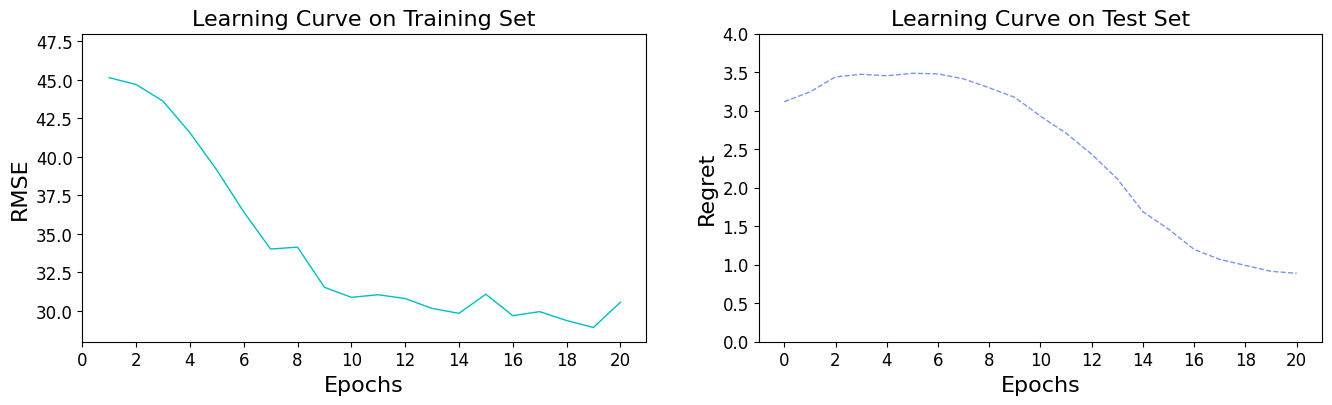

In [50]:
visLearningCurve(loss_log, loss_log_regret)

Try on test set 

In [ ]:
# Function to get DA plan for a given regression model
def get_DA_plan(reg, optmodel, loader_test, wind_test):
    forward_bids = []
    hydrogen_plan = []
    reg.eval()
    for i, data in enumerate(loader_test):
        x, c, w, z = data
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        predicted_costs = reg(x).detach().numpy()[0]
        model = optmodel(realized=wind_test[i])
        model.setObjective(predicted_costs)
        forward, hydrogen = model.get_plan()
        forward_bids.extend(forward)
        hydrogen_plan.extend(hydrogen)
    return forward_bids, hydrogen_plan

# Function to get number of parameters in neural network
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
forward_bids, hydrogen_plan = get_DA_plan(reg, hydrogenPlanning, loader_test, wind_test)

In [24]:
# Save bids and hydrogen production to csv
pd.DataFrame({"forward bid" : forward_bids,"hydrogen production" : hydrogen_plan}).to_csv("SLO_noAlgo13_final.csv", index=False)

In [51]:
count_parameters(reg)

8864

# Now with Algorithm 13 implemented

In [40]:
from pyepo.model.grb import optGrbModel
num_item = 5*n_periods # number of predictions (Forward bid and Hydrogen)

# optimization model
class hydrogenPlanning_2(optGrbModel):
    def __init__(self, realized, *args, **kwargs):        
        #Fixed parameters
        self.max_elec = 10
        self.max_wind = 10
        self.nominal_wind = 10
        self.min_production = 50
        self.periods = np.arange(len(realized))
        self.E_real = realized
        super().__init__()

    def _getModel(self):

        self.initial_plan = Model("Gurobi.Optimizer")

        # Definition of variables
        self.var = self.initial_plan.addVars((5*len(self.periods)), name="x")
        # 1-24: Hydrogen plan, 25-48: Forward bids, 49-72: Up regulation, 73-96: Down regulation
        #97-120: Hydrogen extra
        # Objective: Maximize profit
        self.initial_plan.modelSense = GRB.MAXIMIZE

        # Constraints
        # Max capacity
        self.initial_plan.addConstr(self.min_production <= gp.quicksum(self.var[t] for t in self.periods), name="min_hydrogen_production")
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"elec_capacity_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_elec, name=f"elec_capacity_ub_{t}")
        for t in np.arange(len(self.periods),2*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= -self.max_elec, name=f"wind_capacity_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_wind, name=f"wind_capacity_ub_{t}")
        for t in np.arange(2*len(self.periods),3*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"up_regulation_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= 10*self.max_wind, name=f"up_regulation_ub_{t}")
        for t in np.arange(3*len(self.periods),4*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"dw_regulation_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= 10*self.max_wind, name=f"dw_regulation_ub_{t}")

        #notsure about this one
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.var[t] + self.var[t+24] <= self.max_wind, name=f"{t}")
        #added constraints for extra hydrogen
        for t in np.arange(4*len(self.periods),5*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= -self.max_elec, name=f"extra_hydrogen_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_elec, name=f"extra_hydrogen_ub_{t}")
       #Balance constraint 
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.E_real[t] - self.var[t] - self.var[t+24] == -self.var[t+48] + self.var[t+72] + self.var[t+96], name=f"balancing_{t}")


        # Reference point is from extra hydrogen, so initial has to be tt-24*4
        for ix, t in enumerate(np.arange(4*len(self.periods),5*len(self.periods))):
            if ix == 0:
                # Must not reduce below min production
                self.initial_plan.addConstr(self.var[t] >= 
                                            - (gp.quicksum(self.var[tt] for tt in np.arange(ix,len(self.periods))) - self.min_production), "c1")
            else:
                # Must not reduce below min production - can do if we have produced more than min production earlier
                self.initial_plan.addConstr(self.var[t] >= 
                                            - (gp.quicksum(self.var[tt-24*4] 
                                                           + self.var[tt] for tt in np.arange(4*len(self.periods),t-1)) +
                                          gp.quicksum(self.var[tt-24*4] for tt in np.arange(t,5*len(self.periods))) 
                                          - self.min_production), "c2")
            # Cannot produce more than max capacity:
            self.initial_plan.addConstr(self.var[t] + self.var[t-24*4] <= self.max_elec, "Extra hydrogen production capacity")
            self.initial_plan.addConstr(self.var[t] + self.var[t-24*4] >= 0, "Extra hydrogen production capacity")        
            """"
            how to implement this? without cost or objective function?
            if lambda_H < price_DW[t,s]
                @constraint(SAA, EH_extra[t,s] <= 0)
            end
            """
        
        return self.initial_plan, self.var
    
    def setObjective(self, c):
        # Objective: Maximize profit
        self.initial_plan.setObjective(gp.quicksum(self.var[t]*c[t] for t in np.arange(0,5*len(self.periods))), GRB.MAXIMIZE)
        for t in np.arange(4*len(self.periods),5*len(self.periods)):
            if c[t] < c[t-24]: # if lambda_H[t] < price_DW[t]
                    self.initial_plan.addConstr(self.var[t] <= 0)
    
    def get_plan(self):
        self.initial_plan.optimize()
        self.initial_plan.update()
        x_values = []
        for var in self.initial_plan.getVars():
            x_values.append(var.x)
        hydrogen = x_values[0:len(self.periods)]
        forward_bids = x_values[len(self.periods):2*len(self.periods)]
        return forward_bids, hydrogen

In [45]:
c_train = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], lambda_H_list]) for d in range(int(n_hours/n_periods))])
#c_val   = c_train[-n_val_days:,:]
#c_train   = c_train[:(n_days-n_val_days),:]
c_test = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], lambda_H_list]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])


from pyepo.data.datasetParams import optDatasetParams
dataset_train = optDatasetParams(hydrogenPlanning_2, x_train, c_train, wind_train)
#dataset_val = optDatasetParams(hydrogenPlanning, x_val, c_val, wind_val)
dataset_test = optDatasetParams(hydrogenPlanning_2, x_test, c_test, wind_test)

batch_size = 1
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
#loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|██████████| 365/365 [00:05<00:00, 62.01it/s]


Optimizing for optDataset...


100%|██████████| 365/365 [00:05<00:00, 63.62it/s]


In [54]:
for data in loader_test:
    print(len(data))
    break


4


In [57]:
best_config["train_data"]

In [59]:
# Redo training with best hyperparameters
import time as time
best_config={
        'lr': 1e-2,
        'gamma': 0.99,
        'num_epochs': 30,
        'neurons': 64,
        'dropout': 0.7,
        "method_name": "spo+",
        "val" : False,
        "optmodel" : hydrogenPlanning_2,
        "num_item" : num_item,
    }
start_time = time.time()
reg, loss_log, loss_log_regret = trainModel(best_config) 
run_time = time.time() - start_time

<


  0%|          | 0/69 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\Frede\AppData\Local\Temp\ipykernel_16204\3738505320.py", line 25, in trainModel
    loss_log_regret = [regretParams(reg, config.optmodel, config.test_data, wind_test)]
  File "c:\Users\Frede\Documents\DTU\2024\Special Course\git\main_folder\.venv\lib\site-packages\pyepo\metric\regretParams.py", line 32, in regretParams
    x, c, w, z = data
ValueError: not enough values to unpack (expected 4, got 1)


ValueError: not enough values to unpack (expected 4, got 1)

In [60]:
forward_bids = []
hydrogen_plan = []
reg.eval()
for i, data in enumerate(loader_test):
    x, c, w, z = data
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    predicted_costs = reg(x).detach().numpy()[0]
    model = hydrogenPlanning_2(realized=wind_test[i])
    model.setObjective(predicted_costs)
    forward, hydrogen = model.get_plan()
    forward_bids.extend(forward)
    hydrogen_plan.extend(hydrogen)

In [62]:
pd.DataFrame({"forward bid" : forward_bids,"hydrogen production" : hydrogen_plan}).to_csv("SLO_Algo13_final.csv", index=False)
count_parameters(reg)

9656

In [61]:
run_time

131.46343874931335